In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import trange


In [2]:
class Arm:
    # id to identify each arm
    # mean :Q* 
    #std :
    #Q : True value
    # count : The number of times the arm was selected
    #p the probabilty of each arm to be selected (using this on Softmax algorithm) 
    def __init__(self,id,mean,std):
        self.id=id
        self.mean=mean
        self.std=std
        self.Q=0
        self.count=0
        self.p=0
        
    def Reset_arm(self):
        self.Q=0
        self.count=0
        
    def getReward(self):
        reward = np.random.normal(self.mean,self.std) 
        self.count += 1
        self.Q += (reward - self.Q) / self.count
        return reward
    

In [3]:
class Bandit:
    #arms : list of arms
    #k  number of arms
    #epsilon : egreedy poarameter
    #algo : to specify wich algorithm we are using (random,greedy,softmax)
    #softmax_param :softmax parametre
    def __init__(self,arms, epsilon=0.,algo="Random",softmax_param=0):
        self.arms = arms
        self.k=len(self.arms)
        self.epsilon = epsilon
        self.algo=algo
        self.softmax_param=softmax_param
        
    #Reset the bandit
    def reset(self):
        for arm in self.arms:
            arm.Reset_arm()
            
        
    #argmax function used in e greedy algorithm
    def argmax(self):
        Q_list=[arm.Q for arm in self.arms]
        return random.choice([arm for arm in self.arms if arm.Q==max(Q_list)])
    #selection method of Softmax algorithm
    def select_softmax(self):
        #getting the probailty of each arm
        for arm in self.arms:
            sum = 0
            for arm_sum in self.arms:
                sum += np.exp(arm_sum.Q / self.softmax_param)
            arm.p = np.exp(arm.Q / self.softmax_param) / sum        
        prob=[arm.p for arm in self.arms]   
        prob = np.array(prob)
        prob /= prob.sum()  # normalize
        #use those probabilities to select the arm
        return  np.random.choice(self.arms, p=prob)
    
    def select_action(self):
        if self.algo=="Softmax":
            return self.select_softmax()
        if self.algo=="random":
            return np.random.choice(self.arms)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.arms)
        #otherwise Egreedy algorithm
        return self.argmax()





In [4]:
#main Function to the execute ,return average reward ,selected times of each arm,True value of each arm over time
def Run(bandit,runs=2000, time=1000,new_eps=False,new_P=False):
    rewards = np.zeros((runs, time))
    Q_value = np.zeros((runs,bandit.k+1, time))
    selected_times=[]
    for r in trange(runs):
        bandit.reset()
        for t in range(time):
            if new_eps:
                bandit.epsilon=1/np.sqrt(t+1)
            if new_P:
                bandit.softmax_param=4*((1000-t+1)/1000)
            action = bandit.select_action()
            reward = action.getReward()
            selected_times.append(action.id)
            rewards[r, t] = reward
            for ar in bandit.arms:
                Q_value[r,ar.id,t]=ar.Q
    mean_rewards = rewards.mean(axis=0)
    Q_value=Q_value.mean(axis=0)
    return  mean_rewards,selected_times,Q_value


In [5]:
#list of arms 
Arm1=Arm(1,2,0.7)
Arm2=Arm(2,0.7,0.8)
Arm3=Arm(3,1.3,2)
Arm4=Arm(4,2.2,1.2)
arms=[Arm1,Arm2,Arm3,Arm4]

In [6]:
results=[]

In [7]:
results.append([Run( Bandit(arms,softmax_param=0.1,algo="Softmax")),"Softmax 0.1"])
results.append([Run(Bandit(arms,softmax_param=1,algo="Softmax")),"Softmax 1"])
results.append([Run(Bandit(arms,algo="random")),"Random"])
results.append([Run(Bandit(arms,epsilon=0,algo="gready")),"e-greedy 0"])              
results.append([Run(Bandit(arms,epsilon=0.1,algo="gready")),"e-greedy 0.1"])
results.append([Run( Bandit(arms,epsilon=0.2,algo="gready")),"e-greedy 0.2"])
results.append([Run( Bandit(arms,algo="gready"),new_eps=True),"e-greedy 1/sqrt(t)"])
results.append([Run( Bandit(arms,algo="Softmax"),new_P=True),"Softmax 4*(1000-t)/1000"])

100%|██████████| 2000/2000 [03:23<00:00,  9.82it/s]


In [8]:
#each of the results element contains (data to plot ,and algorithm name)
#data contains : average_reward ,selected times,Q_value

## Exercise 1.1

• plot of the cumulative average reward over time for each algorithm (One graph).

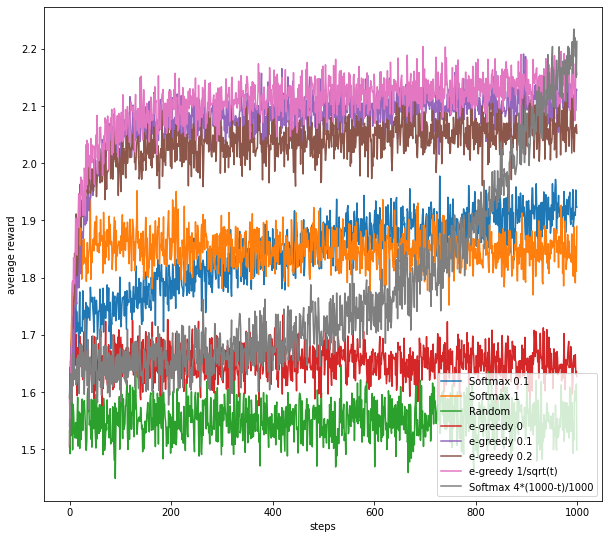

In [9]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
#data[0]: gives us the average rewards
for data,algo in results:
    plt.plot(data[0], label=algo)
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

#plt.show()
plt.savefig("average_reward_1_3.png")

• plot per arm showing the Q ∗ a i of that action along with the actual Q a i estimate over time (all
action selection methods should be depicted on the same plot!) (One graph per arm).

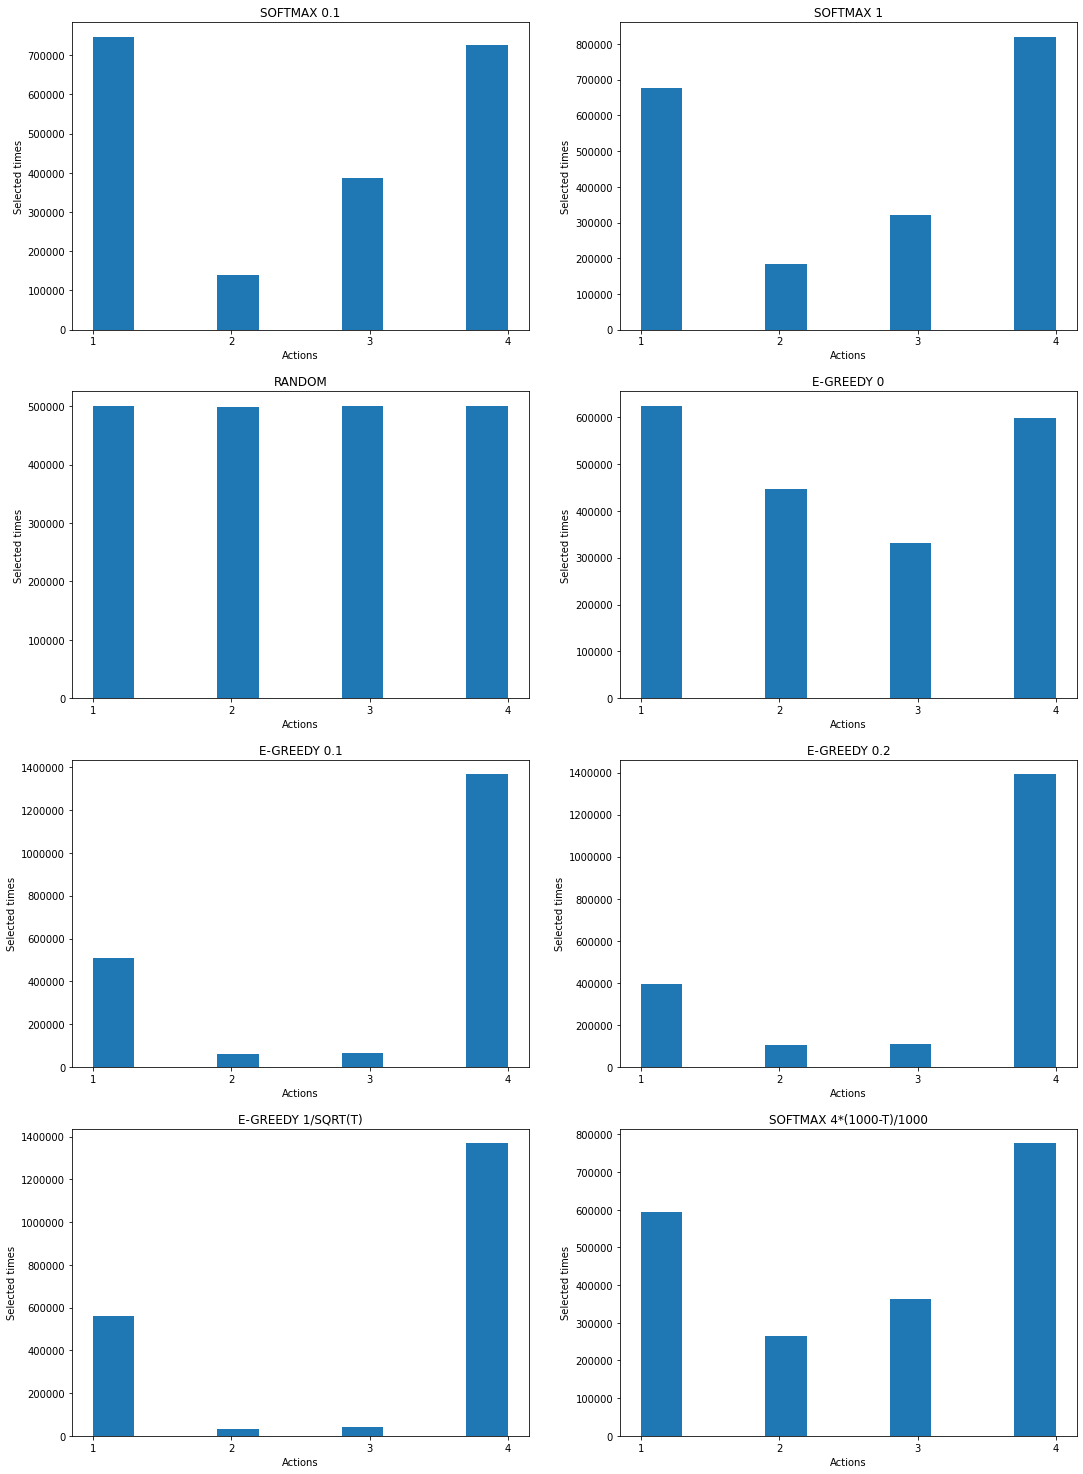

In [10]:
#data[0]: data to plot and it contains average reward,selected_values (data[0][1]) ,Q_value
#data[1]: algorithm name
labels = ['1', '2', '3', '4']
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(18, 26))
for ax, data in zip(ax.flatten(), results):
    ax.hist(data[0][1])
    ax.set(title=data[1].upper(), xlabel='Actions', ylabel='Selected times')
    ax.ticklabel_format(style='plain')
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(labels)

#plt.show()
plt.savefig("Histograme_1_3.png")

• histogram showing the number of times each action is selected (One
graph per action selection strategy).

In [11]:
#Q* of each arm
q_star=np.zeros((len(arms)+1,1000))
for ar in arms:
    q_star[ar.id]=ar.mean


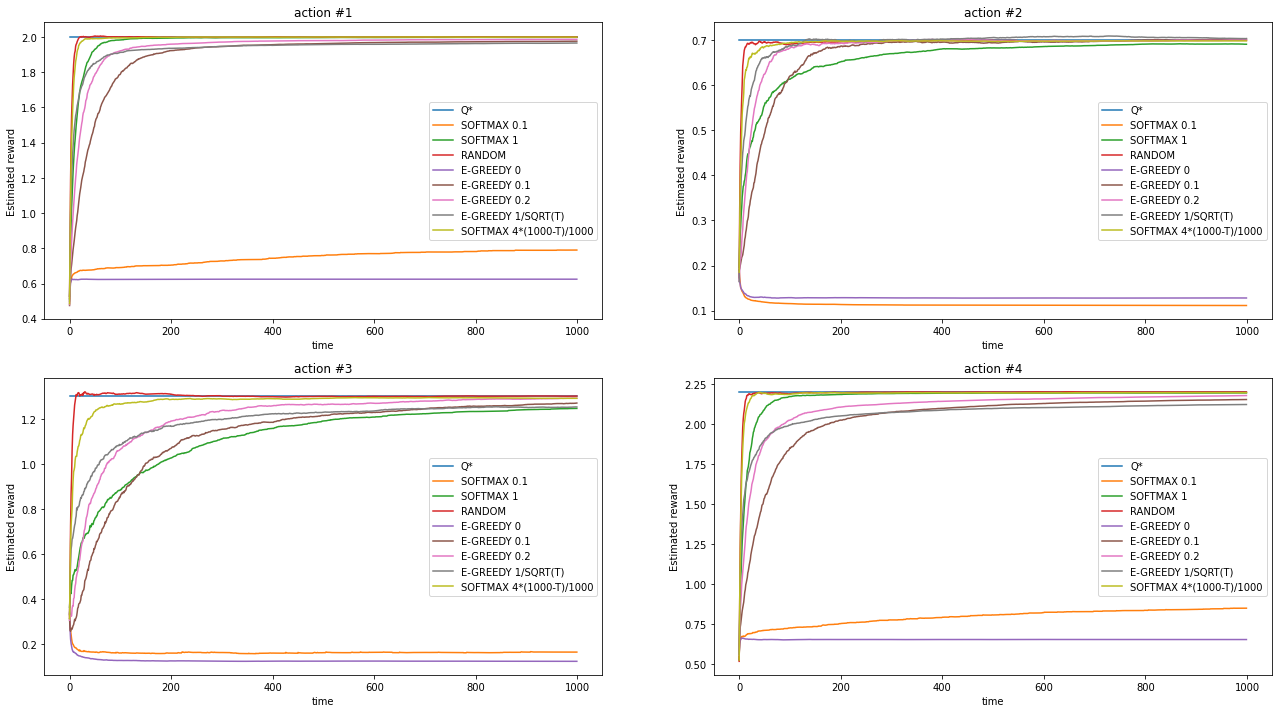

In [12]:
#data[0]: data to plot and it contains average reward,selected_values  ,Q_value (data[0][2])
# data[0][2][k] : k for each arm
#data[1]: algorithm name
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22, 12))
for ax,k in zip(ax.flatten(),range(1,5)):
        ax.plot(q_star[k],label="Q*")
        for data in results:          
            ax.plot(data[0][2][k],label=data[1].upper())
            ax.set(title="action #"+str(k), xlabel='time',ylabel="Estimated reward")
            ax.legend()
#plt.show()
plt.savefig("Estimated_value_1_3.png")    